<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAMed_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customized Segment Anything Model for Medical Image Segmentation
### [[Paper](https://arxiv.org/pdf/2304.13785.pdf)] [[Github](https://github.com/hitachinsk/SAMed)]
---
[Kaidong Zhang](https://hitachinsk.github.io/), and [Dong Liu](https://faculty.ustc.edu.cn/dongeliu/), technical report, 2023

All rights reserved by the authors of SAMed

We provide the entire inference pipeline in this page.

# Setup environment

In [1]:
!pip install -q einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 780.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

# Download codes, pretrained weights and test data

In [2]:
# prepare codes
import os
CODE_DIR = 'samed_codes'
os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/hitachinsk/SAMed.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'samed_codes'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 225 (delta 86), reused 72 (delta 72), pack-reused 123
Receiving objects: 100% (225/225), 635.01 KiB | 33.42 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [3]:
#dataset
!gdown https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
import zipfile
with zipfile.ZipFile('Slices.zip', 'r') as zip_ref:
    zip_ref.extractall()

#weights
!gdown https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr #'epoch_159.pth'
!gdown https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg #'sam_vit_b_01ec64.pth'

Downloading...
From: https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
To: /content/samed_codes/Slices.zip
100% 56.1M/56.1M [00:02<00:00, 25.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
To: /content/samed_codes/epoch_159.pth
100% 19.7M/19.7M [00:00<00:00, 57.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
To: /content/samed_codes/sam_vit_b_01ec64.pth
100% 375M/375M [00:13<00:00, 28.3MB/s]


Dataloader:

/content/samed_codes


Train Sample: 1395 Test Sample: 310


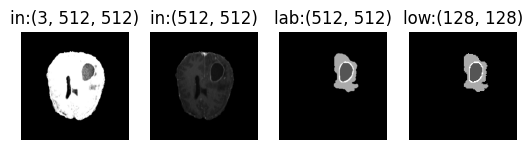

In [1]:
%cd /content/samed_codes
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio.v2 as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.ndimage import zoom
from einops import repeat

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def map_labels(label):
    label_map = {0: 0, 85: 1, 128:0, 170: 2, 255: 3}
    mapped_label = label.copy()
    for k, v in label_map.items():
        mapped_label[label == k] = v
    return mapped_label

class BratsDataset(Dataset):
    def __init__(self, root='brats_train', low_res=None,  transform=None):
        self.img_path_all = glob(root + '/BraTS-GLI-t1c/*.png')
        self.mask_path_all = [img_path.replace('t1c', 'seg') for img_path in self.img_path_all]
        self.transform = transform
        self.low_res = low_res

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        image = iio.imread(self.img_path_all[index])
        image = normalise_intensity(image)
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)
        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        label = iio.imread(self.mask_path_all[index])
        label = map_labels(label)
        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label}
        # if self.transform:
        #     sample = self.transform(sample)
        return sample

train_dataset = BratsDataset(root='Slices/Train', low_res=128)
test_dataset = BratsDataset(root='Slices/Test', low_res=128)
print('Train Sample:', len(train_dataset), 'Test Sample:', len(test_dataset))
sample = train_dataset[7]
input, label, low_res_label = sample['image'],sample['label'], sample['low_res_label']
plt.subplot(1,4,1), plt.axis('OFF'), plt.title('in:{}'.format(input.shape)), plt.imshow(input.transpose(1,2,0))
plt.subplot(1,4,2), plt.axis('OFF'), plt.title('in:{}'.format(input[0].shape)), plt.imshow(input[0], cmap='gray')
plt.subplot(1,4,3), plt.axis('OFF'), plt.title('lab:{}'.format(label.shape)), plt.imshow(label, cmap='gray');
plt.subplot(1,4,4), plt.axis('OFF'), plt.title('low:{}'.format(low_res_label.shape)), plt.imshow(low_res_label, cmap='gray');

SAM Training

In [ ]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

from torch.nn.modules.loss import CrossEntropyLoss
from utils import DiceLoss
import torch.optim as optim

def seed_everything(seed=42):
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

def calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    low_res_logits = outputs['low_res_logits']
    loss_ce = ce_loss(low_res_logits, low_res_label_batch[:].long())
    loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice

def training_per_epoch(model, trainloader, optimizer, iter_num):
    model.train()
    loss_all = []
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
        image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
        outputs = model(image_batch, multimask_output, args.img_size)
        loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all.append(loss.item())
        if args.warmup and iter_num < args.warmup_period:
            lr_ = args.base_lr * ((iter_num + 1) / args.warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
        else:
            if args.warmup:
                shift_iter = iter_num - args.warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
            else:
                shift_iter = iter_num
            lr_ = args.base_lr * (1.0 - shift_iter / args.max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        iter_num = iter_num + 1

    return np.mean(loss_all)


def test_per_epoch(model, testloader):
    model.eval()
    loss_per_epoch, dice_per_epoch = [], []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch, multimask_output, args.img_size)
            loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice)
    return np.mean(loss_per_epoch), np.mean(dice_per_epoch)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=3)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='/output')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=12, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=5, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    args = parser.parse_args([])
    args.output_dir = 'results'
    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'epoch_159.pth'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed_everything()
    os.makedirs(args.output_dir, exist_ok = True)

    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    pkg = import_module(args.module)
    net = pkg.LoRA_Sam(sam, args.rank).cuda()
    # net.load_lora_parameters(args.lora_ckpt)
    multimask_output = True if args.num_classes > 1 else False
    train_dataset = BratsDataset(root='Slices/Train', low_res=128)
    test_dataset = BratsDataset(root='Slices/Test', low_res=128)
    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset), 'batch:', args.batch_size)

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)
    b_lr = args.base_lr / args.warmup_period
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    iter_num = 0

    best_epoch, best_loss = 0.0, np.inf
    for epoch in range(args.max_epochs):
        loss_training = training_per_epoch(net, trainloader, optimizer, iter_num)
        loss_testing, dice = test_per_epoch(net, testloader)

        if loss_testing < best_loss:
            best_loss = loss_testing
            best_epoch = epoch
            net.save_lora_parameters(os.path.join(args.output_dir, 'model_best.pt'))

        print('--- Epoch {}\{}: Training loss = {:.4f}, Testing: [loss = {:.4f}, dice = {:.4f}], Best loss = {:.4f}, Best epoch = {} '.\
            format(epoch, args.max_epochs, loss_training, loss_testing, dice, best_loss, best_epoch))







/content/samed_codes
Training on: cuda train sample size: 1395 test sample size: 310


Old data

In [10]:
!gdown https://drive.google.com/uc?id=1RczbNSB37OzPseKJZ1tDxa5OO1IIICzK
!unzip test_vol_h5.zip

Downloading...
From: https://drive.google.com/uc?id=1RczbNSB37OzPseKJZ1tDxa5OO1IIICzK
To: /content/samed_codes/test_vol_h5.zip
100% 267M/267M [00:03<00:00, 84.0MB/s]
Archive:  test_vol_h5.zip
   creating: test_vol_h5/
  inflating: test_vol_h5/case0038.npy.h5  
  inflating: test_vol_h5/case0036.npy.h5  
  inflating: test_vol_h5/case0035.npy.h5  
  inflating: test_vol_h5/case0032.npy.h5  
  inflating: test_vol_h5/case0029.npy.h5  
  inflating: test_vol_h5/case0025.npy.h5  
  inflating: test_vol_h5/case0022.npy.h5  
  inflating: test_vol_h5/case0008.npy.h5  
  inflating: test_vol_h5/case0004.npy.h5  
  inflating: test_vol_h5/case0003.npy.h5  
  inflating: test_vol_h5/case0001.npy.h5  
  inflating: test_vol_h5/case0002.npy.h5  


In [9]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
# from utils import test_single_volume
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

from torchvision import transforms
from datasets.dataset_synapse import Synapse_dataset, RandomGenerator


volume_path = 'test_vol_h5'
list_dir = './lists/lists_Synapse/'
low_res = img_embedding_size * 4
num_classes = 8

dataset_config = {
        'Synapse': {
            'Dataset': Synapse_dataset,
            'volume_path': volume_path,
            'list_dir': list_dir,
            'num_classes': num_classes,
            'z_spacing': 1
        }
    }
db_config = dataset_config['Synapse']
db_test = db_config['Dataset'](base_dir=volume_path, list_dir=list_dir, split="test_vol", transform=transforms.Compose(
                                   [RandomGenerator(output_size=[args.img_size, args.img_size], low_res=[low_res, low_res])]))
db_test[0]['image'].shape, db_test[0]['label'].shape, db_test[0]['low_res_label'].shape

/content/samed_codes


(torch.Size([3, 512, 512]), torch.Size([512, 512]), torch.Size([128, 128]))

In [10]:
low_res

128

In [ ]:
import h5py
filepath = '/content/samed_codes/test_vol_h5/case0001.npy.h5'
data = h5py.File(filepath)
image, label = data['image'][:], data['label'][:]
image.shape, label.shape, np.unique(label)

((147, 512, 512),
 (147, 512, 512),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32))

Inference:

In [ ]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
# from utils import test_single_volume
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat



class_to_name = {1: 'spleen', 2: 'right kidney', 3: 'left kidney', 4: 'gallbladder', 5: 'liver', 6: 'stomach', 7: 'aorta', 8: 'pancreas'}

def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    elif pred.sum() > 0 and gt.sum() == 0:
        return 1, 0
    else:
        return 0, 0

def test_single_volume(image, label, net, classes, multimask_output, image_size=[512, 512],
                       test_save_path=None, case=None):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    print('image, label:', image.shape, label.shape )

    prediction = np.zeros_like(label)
    for ind in range(image.shape[0]):
        slice = image[ind, :, :]
        x, y = slice.shape[0], slice.shape[1]
        inputs = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()
        inputs = repeat(inputs, 'b c h w -> b (repeat c) h w', repeat=3)
        net.eval()
        with torch.no_grad():
            # print('model input:', inputs.shape)
            outputs = net(inputs, multimask_output, image_size[0])
            output_masks = outputs['masks']
            out = torch.argmax(torch.softmax(output_masks, dim=1), dim=1).squeeze(0)
            out = out.cpu().detach().numpy()
            out_h, out_w = out.shape
            if x != out_h or y != out_w:
                pred = zoom(out, (x / out_h, y / out_w), order=0)
            else:
                pred = out
            prediction[ind] = pred

    metric_list = []
    for i in range(1, classes + 1):
        metric_list.append(calculate_metric_percase(prediction == i, label == i))

    return metric_list

def inference(args, multimask_output, db_config, model, test_save_path=None):
    db_test = db_config['Dataset'](base_dir=args.volume_path, list_dir=args.list_dir, split='test_vol')
    print('sample size:', len(db_test))
    testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)
    logging.info(f'{len(testloader)} test iterations per epoch')
    model.eval()
    metric_list = 0.0
    for i_batch, sampled_batch in tqdm(enumerate(testloader)):
        h, w = sampled_batch['image'].shape[2:]
        image, label, case_name = sampled_batch['image'], sampled_batch['label'], sampled_batch['case_name'][0]
        print(image.shape, label.shape)
        metric_i = test_single_volume(image, label, model, classes=args.num_classes, multimask_output=multimask_output,
                                      image_size=[args.img_size, args.img_size],
                                      test_save_path=test_save_path, case=case_name)
        metric_list += np.array(metric_i)
        print('idx %d case %s mean_dice %f mean_hd95 %f' % (
            i_batch, case_name, np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))
        logging.info('idx %d case %s mean_dice %f mean_hd95 %f' % (
            i_batch, case_name, np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))
        if i_batch == 0:
            break
    metric_list = metric_list / len(db_test)
    for i in range(1, args.num_classes + 1):
        try:
            logging.info('Mean class %d name %s mean_dice %f mean_hd95 %f' % (i, class_to_name[i], metric_list[i - 1][0], metric_list[i - 1][1]))
        except:
            logging.info('Mean class %d mean_dice %f mean_hd95 %f' % (i, metric_list[i - 1][0], metric_list[i - 1][1]))
    performance = np.mean(metric_list, axis=0)[0]
    mean_hd95 = np.mean(metric_list, axis=0)[1]
    logging.info('Testing performance in best val model: mean_dice : %f mean_hd95 : %f' % (performance, mean_hd95))
    logging.info("Testing Finished!")
    return 1


def config_to_dict(config):
    items_dict = {}
    with open(config, 'r') as f:
        items = f.readlines()
    for i in range(len(items)):
        key, value = items[i].strip().split(': ')
        items_dict[key] = value
    return items_dict

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=8)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='/output')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    args = parser.parse_args([])
    args.volume_path = 'test_vol_h5'
    args.output_dir = 'results'
    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'epoch_159.pth'

    if args.config is not None:
        # overwtite default configurations with config file\
        config_dict = config_to_dict(args.config)
        for key in config_dict:
            setattr(args, key, config_dict[key])

    if not args.deterministic:
        cudnn.benchmark = True
        cudnn.deterministic = False
    else:
        cudnn.benchmark = False
        cudnn.deterministic = True
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    dataset_name = args.dataset
    dataset_config = {
        'Synapse': {
            'Dataset': Synapse_dataset,
            'volume_path': args.volume_path,
            'list_dir': args.list_dir,
            'num_classes': args.num_classes,
            'z_spacing': 1
        }
    }
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    # register model
    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    pkg = import_module(args.module)
    net = pkg.LoRA_Sam(sam, args.rank).cuda()

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)

    if args.num_classes > 1:
        multimask_output = True
    else:
        multimask_output = False

    # initialize log
    log_folder = os.path.join(args.output_dir, 'test_log')
    os.makedirs(log_folder, exist_ok=True)
    logging.basicConfig(filename=log_folder + '/' + 'log.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))

    if args.is_savenii:
        test_save_path = os.path.join(args.output_dir, 'predictions')
        os.makedirs(test_save_path, exist_ok=True)
    else:
        test_save_path = None
    inference(args, multimask_output, dataset_config[dataset_name], net, test_save_path)

/content/samed_codes
sample size: 12


0it [00:00, ?it/s]

torch.Size([1, 148, 512, 512]) torch.Size([1, 148, 512, 512])
image, label: (148, 512, 512) (148, 512, 512)


0it [02:27, ?it/s]

idx 0 case case0008 mean_dice 0.681535 mean_hd95 16.097952


Testing with command:

In [ ]:
%%bash
python test.py --volume_path test_vol_h5 --output_dir results --ckpt sam_vit_b_01ec64.pth --lora_ckpt epoch_159.pth